In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# resize all imgs in 224x224 as prefered with vgg19
image_size=[224,224]
train_path='/content/drive/MyDrive/datascience projects/malaria_img_classification/Dataset/Train'
valid_path='/content/drive/MyDrive/datascience projects/malaria_img_classification/Dataset/Test'

In [5]:
# transfered learning with imagenet weights
vgg19=VGG19(input_shape=image_size+[3], weights='imagenet', include_top=False)
#we do this +[3] for rgb channels
#include_top is false so that the first layer and last layer is cut and we can add our own inputs and can get out binary classification instead of the numerous classes from the imagenet

80150528/80134624 [==============================] - 0s 0us/step


In [6]:
#the existing weights are no more trained but used directly; we could otherwise just use those weights as initialization and train over them
for layer in vgg19.layers:
  layer.trainable=False
  

In [ ]:
#see first & last layers are cut off
#vgg19.summary()

In [7]:
#to get number of output classes (binary here)
folders= glob('/content/drive/MyDrive/datascience projects/malaria_img_classification/Dataset/Train/*')
len(folders)

2

In [8]:
x=Flatten()(vgg19.output)

In [9]:
prediction=Dense(len(folders),activation='softmax')(x)
model= Model(inputs=vgg19.inputs, outputs=prediction)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
model.compile(
    loss='categorical_crossentropy', #as there are 2 classes
    optimizer='adam',
    metrics=['accuracy']
)
#in case of confusion about the hyperparameters, keras tuner can be tried (need to check this next time)

In [11]:
#finally importing the images 
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
# defining size, batch_size, type
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/datascience projects/malaria_img_classification/Dataset/Train',
                                                 target_size = (224, 224),
                                                 batch_size = 32, #no. of iteration per epoch=total images/batch size
                                                 class_mode = 'categorical')

Found 416 images belonging to 2 classes.


In [13]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/datascience projects/malaria_img_classification/Dataset/Test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 134 images belonging to 2 classes.


In [14]:
# fit the model
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
13/13 [==============================] - 94s 6s/step - loss: 1.1838 - accuracy: 0.5793 - val_loss: 0.5115 - val_accuracy: 0.7239
Epoch 2/50
13/13 [==============================] - 7s 503ms/step - loss: 0.5280 - accuracy: 0.7452 - val_loss: 0.7283 - val_accuracy: 0.6269
Epoch 3/50
13/13 [==============================] - 7s 507ms/step - loss: 0.4670 - accuracy: 0.7620 - val_loss: 0.5119 - val_accuracy: 0.7612
Epoch 4/50
13/13 [==============================] - 7s 511ms/step - loss: 0.3648 - accuracy: 0.8365 - val_loss: 0.4352 - val_accuracy: 0.7313
Epoch 5/50
13/13 [==============================] - 7s 504ms/step - loss: 0.3872 - accuracy: 0.8197 - val_loss: 0.4491 - val_accuracy: 0.7015
Epoch 6/50
13/13 [==============================] - 7s 513ms/step - loss: 0.2761 - accuracy: 0.8966 - val_loss: 0.4215 - val_accuracy: 0.7836
Epoch 7/50
13/13 [==============================] - 7s 536ms/step - loss: 0.2803 - accuracy: 0.8774 - val_loss: 0.6240 - val_accuracy: 0.6866
Epoch 8/

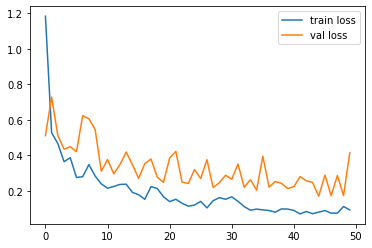

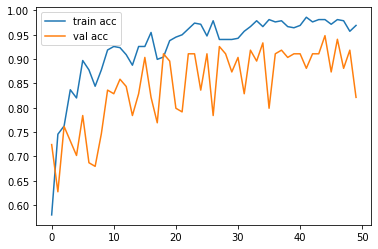

<Figure size 432x288 with 0 Axes>

In [15]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [16]:
# save it as a h5 file
model.save('/content/drive/MyDrive/datascience projects/malaria_img_classification/model_vgg19.h5')

In [17]:
y_pred = model.predict(test_set)
y_pred

array([[3.1435522e-01, 6.8564475e-01],
       [6.3923080e-03, 9.9360764e-01],
       [5.0639570e-02, 9.4936049e-01],
       [6.9371897e-01, 3.0628103e-01],
       [4.4388849e-01, 5.5611157e-01],
       [9.9949908e-01, 5.0085457e-04],
       [9.8789680e-01, 1.2103237e-02],
       [9.9801922e-01, 1.9808307e-03],
       [9.9998271e-01, 1.7247190e-05],
       [2.8177083e-01, 7.1822917e-01],
       [1.3057689e-02, 9.8694229e-01],
       [7.4365181e-01, 2.5634819e-01],
       [9.0922028e-01, 9.0779759e-02],
       [3.7207730e-02, 9.6279228e-01],
       [9.1808730e-01, 8.1912667e-02],
       [3.3973560e-02, 9.6602637e-01],
       [2.7500695e-01, 7.2499311e-01],
       [8.9820254e-01, 1.0179744e-01],
       [2.0055391e-02, 9.7994459e-01],
       [9.9838030e-01, 1.6196705e-03],
       [2.9542899e-01, 7.0457107e-01],
       [9.9939704e-01, 6.0296239e-04],
       [1.9921498e-01, 8.0078501e-01],
       [7.2046530e-01, 2.7953467e-01],
       [6.6912687e-01, 3.3087316e-01],
       [9.7806841e-01, 2.

In [18]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1])

In [20]:
model=load_model('/content/drive/MyDrive/datascience projects/malaria_img_classification/model_vgg19.h5')
img=image.load_img('/content/drive/MyDrive/datascience projects/malaria_img_classification/Dataset/Test/Uninfected/2.png',target_size=(224,224))
x=image.img_to_array(img)
x=x/255
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [21]:
model.predict(img_data)
a=np.argmax(model.predict(img_data), axis=1)
if(a==1):
    print("Uninfected")
else:
    print("Infected")

Uninfected
